# Problem Understanding
Across industries, organizations commonly use time series data, which means any information collected over a regular interval of time, in their operations. Examples include daily stock prices, energy consumption rates, social media engagement metrics and retail demand, among others. Analyzing time series data yields insights like trends, seasonal patterns and forecasts into future events that can help generate profits. For example, by understanding the seasonal trends in demand for retail products, companies can plan promotions to maximize sales throughout the year.

When analyzing time series data, you should undertake a number of steps. First, you need to check for stationarity and autocorrelation. Stationarity is a way to measure if the data has structural patterns like seasonal trends. Autocorrelation occurs when future values in a time series linearly depend on past values. You need to check for both of these in time series data because they’re assumptions that are made by many widely used methods in time series analysis. For example, the autoregressive integrated moving average (ARIMA) method for forecasting time series assumes stationarity. Further, linear regression for time series forecasting assumes that the data has no autocorrelation. Before conducting these processes, then, you need to know if the data is viable for the analysis.

During a time series analysis, you also need to perform trend decomposition and forecast future values. Decomposition allows you to visualize trends in your data, which is a great way to clearly explain their behavior. Finally, forecasting allows you to anticipate future events that can aid in decision making. You can use many different techniques for time series forecasting, but here, we will discuss the autoregressive integrated moving average (ARIMA).

We will be working with publicly available airline passenger time series data

__Data Source:__ https://github.com/AileenNielsen/TimeSeriesAnalysisWithPython/blob/master/data/AirPassengers.csv

# Data Collection

In [125]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.patches as mpatches
import numpy as np

import warnings
warnings.filterwarnings('ignore')


raw_data = pd.read_csv("_air_passengers.csv")

# Convert Month to datetime object
raw_data['Month'] = pd.to_datetime(raw_data['Month'], format='%Y-%m')

# Set index as date
raw_data.index = raw_data['Month']

# Drop column (extra memory no longer needed)
del raw_data['Month']

print(raw_data.head())

            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121


# Preliminary Visual

In [117]:
def plot_config(title, axis, y_title, x_title):
    
    # Main Title
    #figure.suptitle('Categorical Plots')

    # Labels
    axis.set_title(title, fontsize=20)
    axis.set_xlabel(x_title, fontsize=15)
    axis.set_ylabel(y_title, fontsize=15)
    
    # Graph Spins
    # Plot 1: Config
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)
    
    # Tickmark Sizes
    axis.tick_params(axis='both', which='major', labelsize=15)

def create_legend(legend_dict):
    list_patches = []
    for label in legend_dict.keys():
        color = legend_dict[label]
        list_patches.append(mpatches.Patch(color=color, label=label))
        plt.legend(handles=list_patches, loc='upper left', prop={'size': 15})

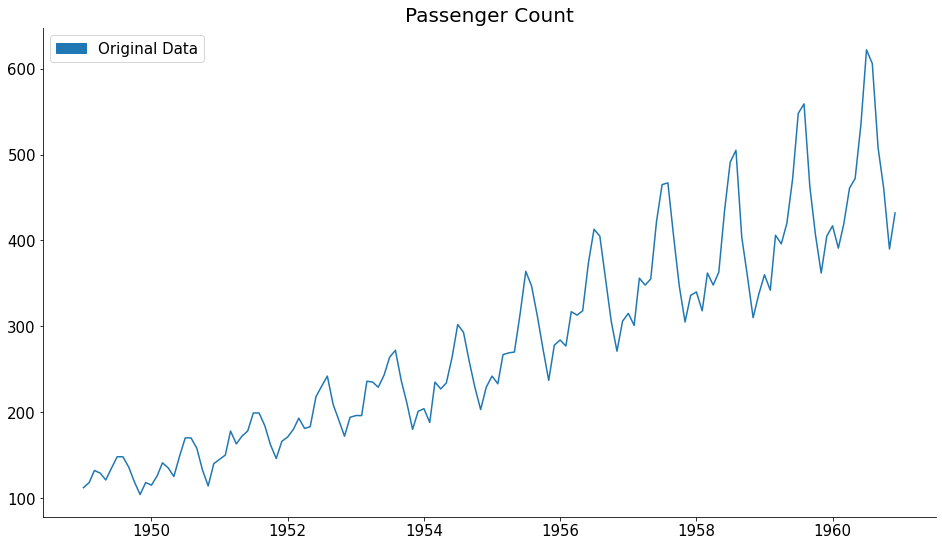

In [118]:
# Creating Figure
figure, axis = plt.subplots(figsize = (16,9))

# Time Histogram
plot_axis = axis
plot_config('Passenger Count', plot_axis,'','')

# Plot Actuals
plt.plot(raw_data['Passengers'], color='#1f77b4');

# Setting Legends
create_legend({'Original Data':'C0'})

# Stationarity - Visual 
Stationarity is a key part of time series analysis. Simply put, stationarity means that the manner in which time series data changes is constant. A stationary time series will not have any trends or seasonal patterns. You should check for stationarity because it not only makes modeling time series easier, but it is an underlying assumption in many time series methods. Specifically, stationarity is assumed for a wide variety of time series forecasting methods including autoregressive moving average (ARMA), ARIMA and Seasonal ARIMA (SARIMA).

If the data is Stationary, then  the data doesn't have any disruptions in the data (pandemic, weather, disasters, etc.)  

We will use the Dickey Fuller test to check for stationarity in our data. This test will generate critical values and a p-value, which will allow us to accept or reject the null hypothesis that there is no stationarity. If we reject the null hypothesis, that means we accept the alternative, which states that there is stationarity.

These values allow us to test the degree to which present values change with past values. If there is no stationarity in the data set, a change in present values will not cause a significant change in past values.

Let’s test for stationarity in our airline passenger data. To start, let’s calculate a seven-month rolling mean:

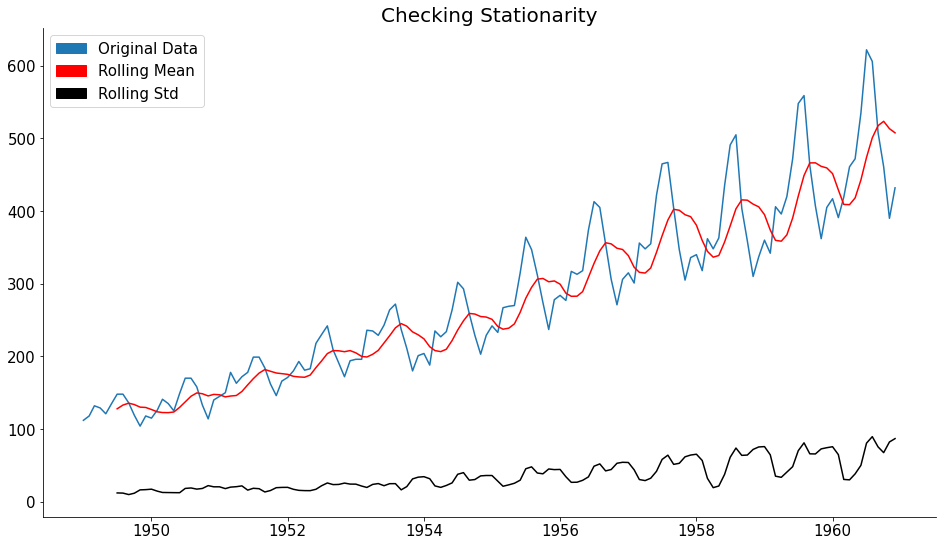

In [119]:
# Taking the rolling mean
rolling_mean = raw_data.rolling(7).mean()
rolling_std = raw_data.rolling(7).std()

# Creating Figure
figure, axis = plt.subplots(figsize = (16,9))

# Time Histogram
plot_axis = axis
plot_config('Checking Stationarity', plot_axis,'','')

# Plot Actuals
plt.plot(raw_data['Passengers'], color='#1f77b4');
plt.plot(raw_data.index, rolling_mean, color="red")
plt.plot(raw_data.index, rolling_std, color="black")

# Setting Legends
create_legend({'Original Data':'C0', 'Rolling Mean':'red', 'Rolling Std':'black'})

# Stationarity - Dickey Fuller 
Next, let’s import the augmented Dickey-Fuller test from the statsmodels package. The documentation for the test can be found here.

Next, let’s pass our data frame into the adfuller method. Here, we specify the autolag parameter as “AIC,” which means that the lag is chosen to minimize the information criterion:

In [120]:
from statsmodels.tsa.stattools import adfuller

adft = adfuller(raw_data,autolag="AIC")

# Adfuller results
print(pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']], 
                          "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]}))

       Values                       Metric
0    0.815369              Test Statistics
1    0.991880                      p-value
2   13.000000             No. of lags used
3  130.000000  Number of observations used
4   -3.481682          critical value (1%)
5   -2.884042          critical value (5%)
6   -2.578770         critical value (10%)


We can see that our data is not stationary from the fact that our p-value is greater than 5 percent and the test statistic is greater than the critical value. We can also draw these conclusions from inspecting the data, as we see a clear, increasing trend in the number of passengers.

# Autocorrelation

Checking for autocorrelation in time series data is another important part of the analytic process. This is a measure of how correlated time series data is at a given point in time with past values, which has huge implications across many industries. For example, if our passenger data has strong autocorrelation, we can assume that high passenger numbers today suggest a strong likelihood that they will be high tomorrow as well.

The Pandas data frame has an autocorrelation method that we can use to calculate the autocorrelation in our passenger data. Let’s do this for a one-month lag:

In [121]:
# Checking Autocorrelation with 1, 3, 6, and 9 months
print("One Month Lag: ", raw_data['Passengers'].autocorr(lag=1))
print("Three Month Lag: ", raw_data['Passengers'].autocorr(lag=3))
print("Six Month Lag: ", raw_data['Passengers'].autocorr(lag=6))
print("Nine Month Lag: ", raw_data['Passengers'].autocorr(lag=9))

One Month Lag:  0.9601946480498523
Three Month Lag:  0.837394765081794
Six Month Lag:  0.7839187959206183
Nine Month Lag:  0.8278519011167601


We see that, even with a nine-month lag, the data is highly autocorrelated. This is further illustration of the short- and long-term trends in the data.

# Autocorrelation - ACF

We can calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.

A plot of the autocorrelation of a time series by lag is called the AutoCorrelation Function, or the acronym ACF. This plot is sometimes called a correlogram or an autocorrelation plot.

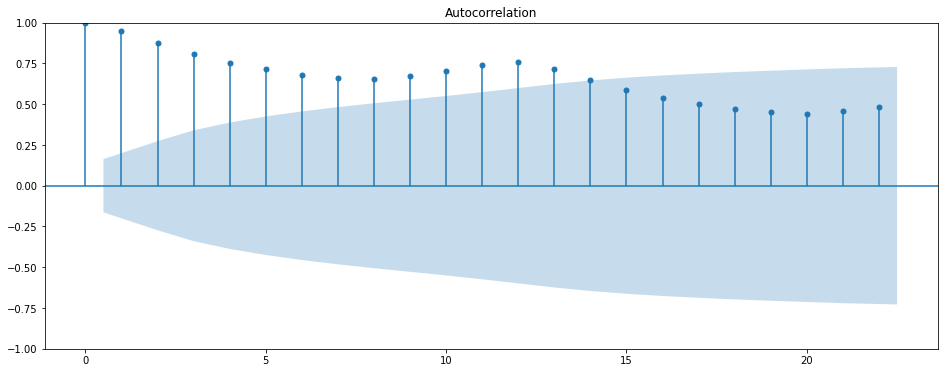

In [122]:
from statsmodels.graphics.tsaplots import plot_acf
figure = plot_acf(raw_data['Passengers'])
figure.set_size_inches((16, 6))
plt.show()

# Autocorrelation - PACF

A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

The autocorrelation for an observation and an observation at a prior time step is comprised of both the direct correlation and indirect correlations. These indirect correlations are a linear function of the correlation of the observation, with observations at intervening time steps.



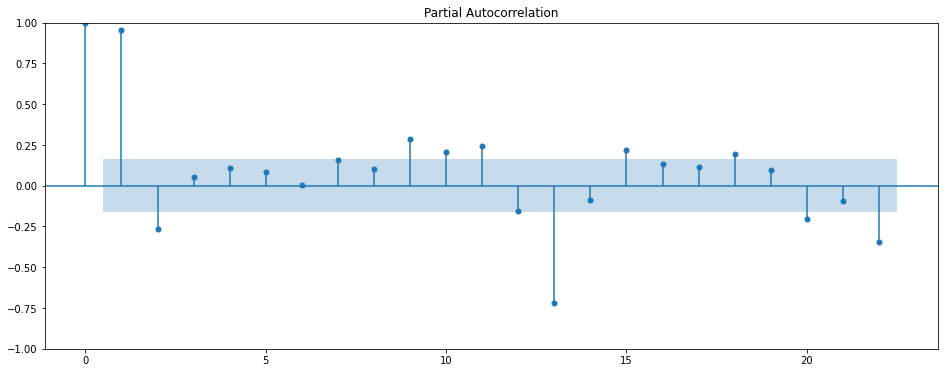

In [123]:
from statsmodels.graphics.tsaplots import plot_pacf
figure = plot_pacf(raw_data['Passengers'])
figure.set_size_inches((16, 6))
plt.show()

# Interpret ACF and PACF

(1) Look for tail off pattern in either ACF or PACF  
(2)If tail off at ACF → AR model → Cut off at PACF will provide order p for AR(p)  
(3)If tail off at PACF → MA model → Cut off at ACF will provide order q for MA(q)  
(4)Tail of at both ACF and PACF → ARMA model  

# Time Series Decomposition

Trend decomposition is another useful way to visualize the trends in time series data. To proceed, let’s import seasonal_decompose from the statsmodels package:

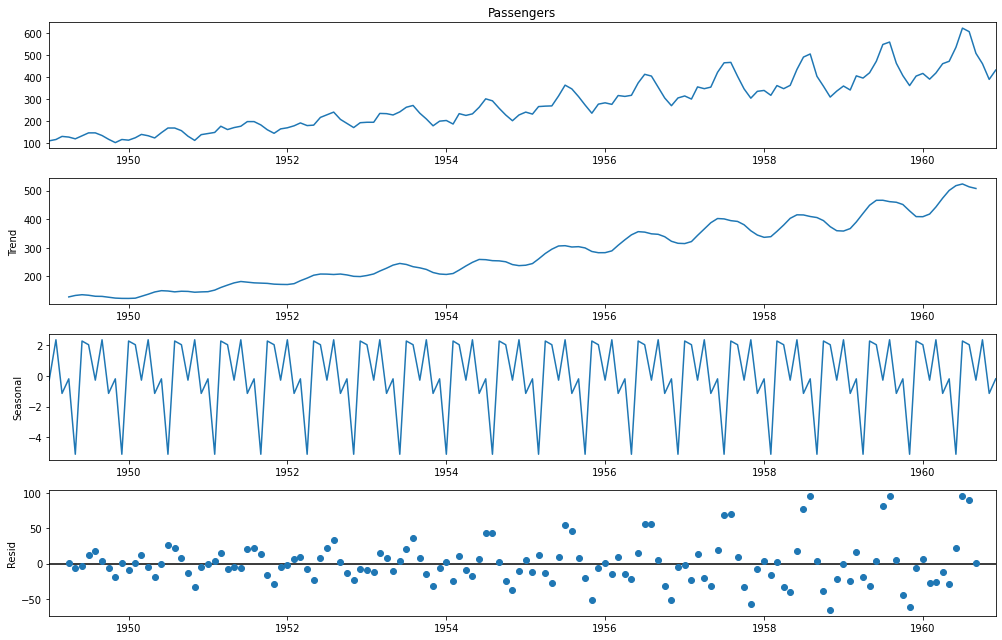

In [124]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decomposition function
decompose = seasonal_decompose(raw_data['Passengers'],model='additive', period=7)

# Plotting time series decomposition
figure = decompose.plot()
figure.set_size_inches((14, 9))
figure.tight_layout()
plt.show()


From this plot, we can clearly see the increasing trend in number of passengers and the seasonality patterns in the rise and fall in values each year.

# Train Test Visual

Time series forecasting allows us to predict future values in a time series given current and past data. Here, we will use the ARIMA method to forecast the number of passengers, which allows us to forecast future values in terms of a linear combination of past values. We will use the auto_arima package, which will allow us to forgo the time consuming process of hyperparameter tuning.

First, let’s split our data for training and testing and visualize the split:

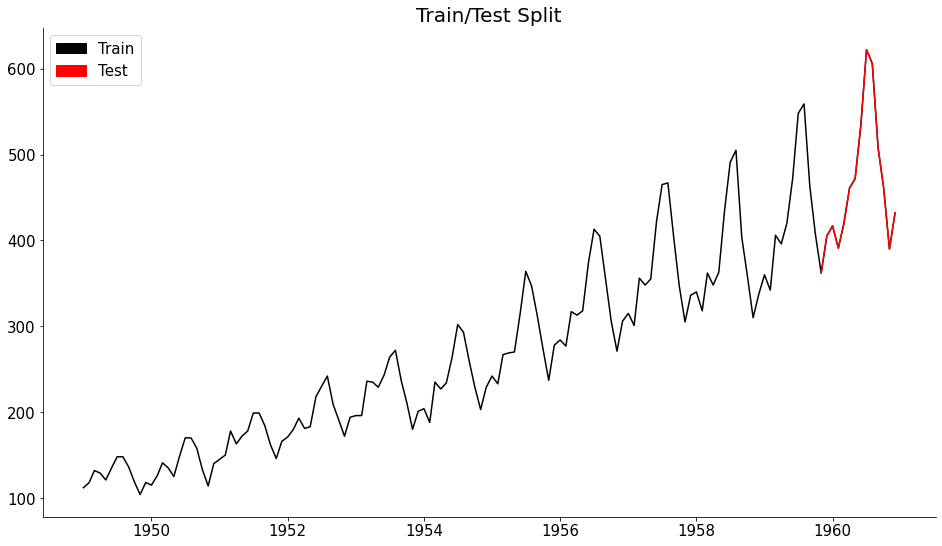

In [101]:
# 90% Train - 10% Test
train_cutoff = int(np.ceil(raw_data.shape[0] * .9))

train = raw_data.iloc[0:train_cutoff]
test = raw_data.iloc[train_cutoff:]

# Creating Figure
figure, axis = plt.subplots(figsize = (16,9))

# Time Histogram
plot_axis = axis
plot_config('Train/Test Split', plot_axis,'','')

# Plot Train/Test
plt.plot(raw_data['Passengers'], color='black');
plt.plot(test['Passengers'], color='red');

# Setting Legends
create_legend({'Train':'black','Test':'red'})

The black line corresponds to our training data and the red line corresponds to our test data.

Let’s import auto_arima from the pdmarima package, train our model and generate predictions:

# Auto Arima

In [163]:
from pmdarima.arima import auto_arima

# Training Model
best_model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True).fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1198.723, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1256.144, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1246.679, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1242.232, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1254.843, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1235.466, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 2.045 seco

Our predictions are shown in green and the actual values are shown in orange.

Finally, let’s calculate root mean squared error (RMSE):

# ARIMA W/ Best Params

In [169]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Init model
sarimax = SARIMAX(train.astype(float), order=best_model.order).fit(disp=False)

# Forecast on Test dataset
raw_data['Test Forecast'] = sarimax.forecast(test.shape[0])

# Test Forecast

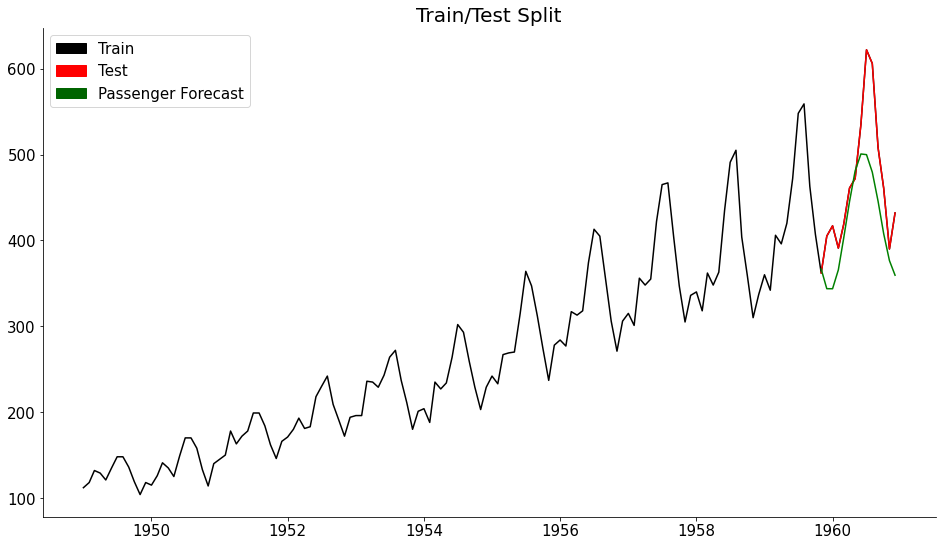

In [164]:
# Creating Figure
figure, axis = plt.subplots(figsize = (16,9))

# Time Histogram
plot_axis = axis
plot_config('Train/Test Split', plot_axis,'','')

# Plot Train/Test
plt.plot(raw_data['Passengers'], color='black');
plt.plot(test['Passengers'], color='red');
plt.plot(raw_data['Test Forecast'], color='green');

# Setting Legends
create_legend({'Train':'black','Test':'red', 'Passenger Forecast':'darkgreen'})

# Time Series Validation - RMSE

In [167]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(test,forecast))
mape = np.mean(np.abs(test['Passengers'] - raw_data['Test Forecast'].dropna()) / test['Passengers'])

print("RMSE: ", rmse)
print("MAPE: ", mape)



RMSE:  82.88506828291915
MAPE:  0.10036978390416959


# 14mo Forecast ARIMA

In [193]:
# Init model
sarimax = SARIMAX(raw_data['Passengers'].astype(float), order=best_model.order).fit(disp=False)

# Forecast on Test dataset
forecast_14mo = sarimax.forecast(14)

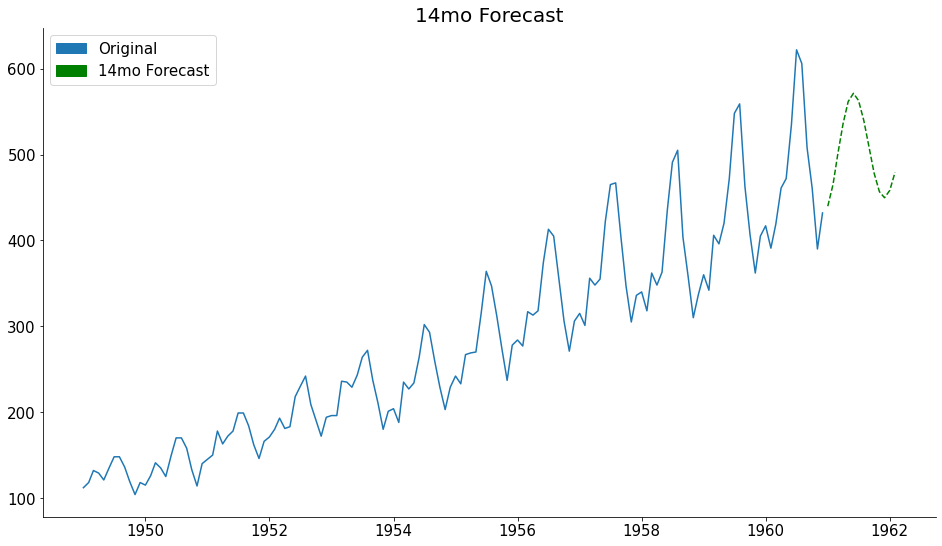

In [194]:
# Creating Figure
figure, axis = plt.subplots(figsize = (16,9))

# Time Histogram
plot_axis = axis
plot_config('14mo Forecast', plot_axis,'','')

# Plot Train/Test
plt.plot(raw_data['Passengers'], color='C0');
plt.plot(forecast_14mo, color='green', linestyle='--');

# Setting Legends
create_legend({'Original':'C0','14mo Forecast':'green'})

# Final Results

In [197]:
forecast_14mo

1961-01-01    439.855056
1961-02-01    465.296850
1961-03-01    500.666343
1961-04-01    535.971556
1961-05-01    561.689034
1961-06-01    571.312393
1961-07-01    562.971690
1961-08-01    539.728638
1961-09-01    508.527782
1961-10-01    478.147333
1961-11-01    456.747761
1961-12-01    449.697760
1962-01-01    458.251679
1962-02-01    479.396843
Freq: MS, Name: predicted_mean, dtype: float64

Conducting time series data analysis is a task that almost every data scientist will face in their career. Having a good understanding of the tools and methods for analysis can enable data scientists to uncover trends, anticipate events and consequently inform decision making. Understanding the seasonality patterns through stationarity, autocorrelation and trend decomposition can guide promotion planning throughout the year, which can improve profits for companies. Finally, time series forecasting is a powerful way to anticipate future events in your time series data, which can also significantly impact decision making. These types of analyses are invaluable to any data scientist or data science team that looks to bring value to their company with time series data